In [326]:
#BT vs SVGD_BT on Iris data. self supervised pretraining, then tune network on the embeddings

#Also, developed a novel algorithm that does the same thing. 

In [537]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import seaborn as sns
import numpy as np
from Base_Stein.SVGD_classes import *
import matplotlib.pyplot as plt


In [538]:
#Let's try on a really simple "toy" dataset. 

In [909]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

#Scale data to have mean 0 and variance 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Split the data set into training and testing

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,y,test_size=0.2,random_state=2)


X_view = X + np.random.uniform(low=-0.5,high=0.5,size=(150,4))

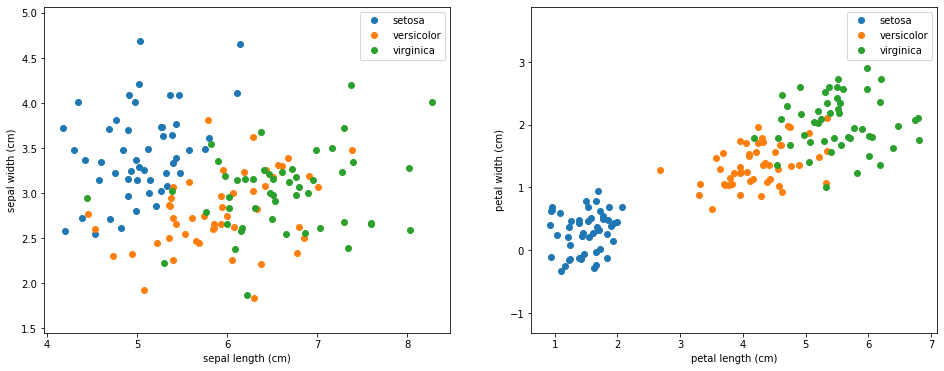

In [910]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
for target, target_name in enumerate(names):
    X_plot = X_view[y == target]
    ax1.plot(X_plot[:, 0], X_plot[:, 1], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.axis('equal')
ax1.legend();

for target, target_name in enumerate(names):
    X_plot = X_view[y == target]
    ax2.plot(X_plot[:, 2], X_plot[:, 3], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax2.set_xlabel(feature_names[2])
ax2.set_ylabel(feature_names[3])
ax2.axis('equal')
ax2.legend();

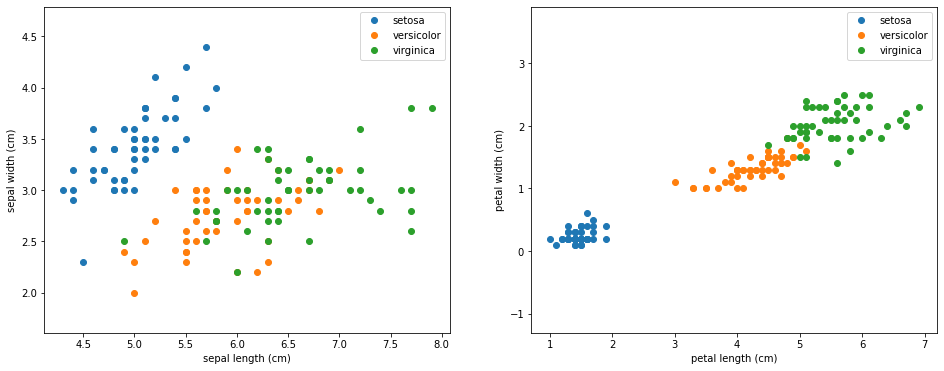

In [911]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax1.plot(X_plot[:, 0], X_plot[:, 1], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.axis('equal')
ax1.legend();

for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax2.plot(X_plot[:, 2], X_plot[:, 3], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax2.set_xlabel(feature_names[2])
ax2.set_ylabel(feature_names[3])
ax2.axis('equal')
ax2.legend();

In [332]:
#Basic embedding network
class Embed(nn.Module):
    
    def __init__(self,xdim,zdim):
        super().__init__()
        self.fc1 = nn.Linear(xdim,xdim)
        self.fc2 = nn.Linear(xdim,zdim)
        self.tanh = nn.Tanh()
        
    def forward(self,x):
        
        x=self.tanh(self.fc1(x))
        x=self.tanh(self.fc2(x))
        
        return x

In [333]:
class Project(nn.Module):
    
    def __init__(self,zdim):
        super().__init__()
        self.fc1 = nn.Linear(zdim,zdim)
        self.fc2 = nn.Linear(zdim,zdim)
        self.tanh = nn.Tanh()

    def forward(self,x):
        
        x=self.tanh(self.fc1(x))
        x=self.fc2(x)
        
        return x

In [951]:
#Implementation of BT

N=X_train.shape[0] #batch size
xdim=X_train.shape[1] #Input dimension
zdim=2 #representation size

embed = Embed(zdim=zdim,xdim=xdim)
project = Project(zdim=zdim)

optimizer = torch.optim.Adam(list(embed.parameters())+list(project.parameters()),lr=0.001)
#Say x sampled from uniform noise.


x = torch.tensor(X_train)
x=x.float()

lambd=(zdim)/(zdim**2 - zdim)
#lambd=0.001
#lambd=1

#lambd =0.1

EYE = torch.eye(zdim)

PSI = lambd*(torch.ones(zdim,zdim)-EYE) + EYE
#Get x1 and x2 by perturbation of x.
#x1 = x + 0.1*torch.rand(N,xdim)
#x2 = x + 0.1*torch.rand(N,xdim)

EPOCHS=4000
for epoch in range(EPOCHS):
    
    #Get x1 and x2 by perturbation of x.
    x1 = x + 0.5*torch.rand(120,4)-0.25
    x2 = x + 0.5*torch.rand(120,4)-0.25

    z1 = project(embed(x1))
    z2 = project(embed(x2))

    # normalize repr. along the batch dimension
    z1_norm = (z1 - z1.mean(0)) / z1.std(0) # NxD
    z2_norm = (z2 - z2.mean(0)) / z2.std(0) # NxD
    
    # cross-correlation matrix
    c = torch.mm(z1_norm.T, z2_norm) / N # DxD

    # loss
    c_diff = (c - EYE).pow(2) # DxD
    
    # multiply off-diagonal elems of c_diff by lambda, on diagonal by 1
    c_diff=PSI*c_diff
    
    loss = c_diff.sum()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


print(c)
print('{} Should be close to 1'.format(torch.min(torch.diag(c)))) #Should be close to 1
print('{} should be close to 0'.format(torch.max(torch.abs((torch.ones(zdim)-torch.eye(zdim))*c)))) #Should be close to zero



tensor([[ 9.7760e-01, -5.3874e-04],
        [ 2.8716e-02,  9.7586e-01]], grad_fn=<DivBackward0>)
0.9758584499359131 Should be close to 1
0.02871646173298359 should be close to 0


In [1004]:
#NEW tinkering. My adjustments to BT

embed = Embed(zdim=zdim,xdim=xdim)
project = Project(zdim=zdim)

optimizer = torch.optim.Adam(list(embed.parameters())+list(project.parameters()),lr=0.001)
#Say x sampled from uniform noise.

lambd1=(zdim)/(zdim**2 - zdim)

lambd1=1.0

#lambd1=1.0


lambd=0
#lambd=(zdim)/(zdim**2 - zdim)
#lambd=10

EYE = torch.eye(zdim)
PSI = lambd*(torch.ones(zdim,zdim)-EYE) + EYE

criterion = nn.MSELoss()

EPOCHS=4000
for epoch in range(EPOCHS):
    
    #Get x1 and x2 by perturbation of x.
    x1 = x + 0.5*torch.rand(120,4)-0.25
    x2 = x + 0.5*torch.rand(120,4)-0.25

    z1 = project(embed(x1))
    z2 = project(embed(x2))

    # normalize repr. along the batch dimension
    z1_norm = (z1 - z1.mean(0)) / z1.std(0)# NxD
    z2_norm = (z2 - z2.mean(0)) / z2.std(0) # NxD
    
    z1_norm_s = torch.unsqueeze(z1_norm,dim=-1)
    z2_norm_s = torch.unsqueeze(z2_norm,dim=-1)
    
    Particles_1 = torch.cat((z1_norm_s[:,0],z2_norm_s[:,1]),dim=1) #so like (feature_1,feature_2)
    Particles_2 = torch.cat((z1_norm_s[:,1],z2_norm_s[:,0]),dim=1) #so like (feature_2,feature_1)
    
    svgd_1 = trainable_SVGD(N=N,zdim=zdim,eta=0.01)
    svgd_1.Particles = Particles_1.detach()
    
    svgd_2 = trainable_SVGD(N=N,zdim=zdim,eta=0.01)
    svgd_2.Particles = Particles_2.detach()
    
    #Inner loop
    for l in range(1):
    
        g = svgd_1.get_gradient() # "Like forward"
        svgd_1.AdamStep(gradient=g) #"Like step"
        #svgd_1.SgdStep(gradient=g)
        
        g = svgd_2.get_gradient() # "Like forward"
        svgd_2.AdamStep(gradient=g) #"Like step"
        #svgd_2.SgdStep(gradient=g)
    
    loss_1 = criterion(Particles_1,svgd_1.Particles)
    loss_2 = criterion(Particles_2,svgd_2.Particles)
    
    loss_3 = loss_1+loss_2
    
    # cross-correlation matrix
    c = torch.mm(z1_norm.T, z2_norm) / N # DxD
    
    # loss
    c_diff = (c - EYE).pow(2) # DxD
    
    # multiply off-diagonal elems of c_diff by lambda, on diagonal by 1
    c_diff=PSI*c_diff
    
    loss = c_diff.sum() + lambd1*loss_3

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(epoch)

print('{} Should be close to 1'.format(torch.min(torch.diag(c)))) #Should be close to 1
print('{} should be close to 0'.format(torch.max(torch.abs((torch.ones(zdim)-torch.eye(zdim))*c)))) #Should be close to zero


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073


3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754


In [442]:
#Now, train a classifier on the embedding!

class Classifier(nn.Module):
    
    def __init__(self,zdim):
        super().__init__()
        self.fc1 = nn.Linear(zdim,4)
        
    def forward(self,x):
        #x = self.tanh(self.fc1(x))
        #x = F.softmax(self.fc2(x),dim=1)
        x = self.fc1(x)
        return x
        

In [1003]:
#Now train classifier on the training data using the embedding

acc=0
for _ in range(10):
    
#`     embed = Embed(zdim=zdim,xdim=xdim)
#     project = Project(zdim=zdim)

    model = Classifier(zdim=zdim)
    optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
    criterion = nn.CrossEntropyLoss()
    EPOCHS = 1000
    loss_list = np.zeros((EPOCHS,))
    accuracy_list = np.zeros((EPOCHS,))

    y = torch.tensor(y_train)

    for epoch in range(EPOCHS):

        z = embed(x)

        y_pred = model(z)

        loss = criterion(y_pred,y)
        loss_list[epoch] = loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #Record accuracy on training (or test?) set
        with torch.no_grad():
            y_pred = model(z)
            correct = (torch.argmax(y_pred,dim=1) == y).type(torch.FloatTensor)
            accuracy_list[epoch] = correct.mean()
            
    acc+=accuracy_list[-1]
        
print(acc/10)

0.8433333396911621


In [707]:
class Discrim(nn.Module):
    def __init__(self,zdim):
        super().__init__()
        #self.fc1 = nn.Linear(zdim,zdim)
        self.fc2 = nn.Linear(zdim,2)
        #self.tanh = nn.Tanh()
        
    def forward(self,x):
        #x = self.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

In [708]:
target = torch.empty(3, dtype=torch.long).random_(5)

target0 = torch.tensor([0],dtype=torch.long)
target1 = torch.tensor([0],dtype=torch.long)



In [904]:
#New algorithm
model = Discrim(zdim=zdim)
inner_optimizer = torch.optim.Adam(model.parameters(),lr=0.1)

embed = Embed(zdim=zdim,xdim=xdim)
project = Project(zdim=zdim)
outer_optimizer = torch.optim.Adam(list(embed.parameters())+list(project.parameters()),lr=0.001)

criterion = nn.CrossEntropyLoss()

for epoch in range(1000):
    
    X=x[torch.randperm(120),:]
    #model = Discrim(zdim=zdim)
    #inner_optimizer = torch.optim.Adam(model.parameters(),lr=0.03)
    
    loss=0
    meta_loss=0
    for i in range(118):
        
        X_ = X[i]
        A_ = X[i+1]

        x1 = X_ + 1.5*torch.rand(1,4)-0.75
        x2 = X_ + 1.5*torch.rand(1,4)-0.75

        a1 = A_ + 1.5*torch.rand(1,4)-0.75
        a2 = A_ + 1.5*torch.rand(1,4)-0.75

        #Dataset z, Dz
        z1 = project(embed(x1)).detach()
        z2 = project(embed(a1)).detach()

        #Dataset y, Dy
        y1 = project(embed(x2))
        y2 = project(embed(a2))

        #Inner adaptation
        
        loss=(criterion(model(z1),target0) + criterion(model(z2),target1))
        inner_optimizer.zero_grad()
        loss.backward()
        inner_optimizer.step()

        meta_loss = criterion(model(y1),target0) + criterion(model(y2),target1)
        #Outer adaptation
        outer_optimizer.zero_grad()
        meta_loss.backward()
        outer_optimizer.step()

    print(1000*meta_loss)
    print(epoch)

print(y1)
print(x2)

print('done')
        

tensor(1.3673, grad_fn=<MulBackward0>)
0
tensor(0.8055, grad_fn=<MulBackward0>)
1
tensor(0.4456, grad_fn=<MulBackward0>)
2
tensor(0.3251, grad_fn=<MulBackward0>)
3
tensor(0.2390, grad_fn=<MulBackward0>)
4
tensor(0.1700, grad_fn=<MulBackward0>)
5
tensor(0.1396, grad_fn=<MulBackward0>)
6
tensor(0.1180, grad_fn=<MulBackward0>)
7
tensor(0.0870, grad_fn=<MulBackward0>)
8
tensor(0.0759, grad_fn=<MulBackward0>)
9
tensor(0.0684, grad_fn=<MulBackward0>)
10
tensor(0.0601, grad_fn=<MulBackward0>)
11
tensor(0.0507, grad_fn=<MulBackward0>)
12
tensor(0.0412, grad_fn=<MulBackward0>)
13
tensor(0.0355, grad_fn=<MulBackward0>)
14
tensor(0.0341, grad_fn=<MulBackward0>)
15
tensor(0.0303, grad_fn=<MulBackward0>)
16
tensor(0.0273, grad_fn=<MulBackward0>)
17
tensor(0.0197, grad_fn=<MulBackward0>)
18
tensor(0.0203, grad_fn=<MulBackward0>)
19
tensor(0.0173, grad_fn=<MulBackward0>)
20
tensor(0.0169, grad_fn=<MulBackward0>)
21
tensor(0.0151, grad_fn=<MulBackward0>)
22
tensor(0.0131, grad_fn=<MulBackward0>)
23
te

tensor(0., grad_fn=<MulBackward0>)
204
tensor(0., grad_fn=<MulBackward0>)
205
tensor(0., grad_fn=<MulBackward0>)
206
tensor(0., grad_fn=<MulBackward0>)
207
tensor(0., grad_fn=<MulBackward0>)
208
tensor(0., grad_fn=<MulBackward0>)
209
tensor(0., grad_fn=<MulBackward0>)
210
tensor(0., grad_fn=<MulBackward0>)
211
tensor(0., grad_fn=<MulBackward0>)
212
tensor(0., grad_fn=<MulBackward0>)
213
tensor(0., grad_fn=<MulBackward0>)
214
tensor(0., grad_fn=<MulBackward0>)
215
tensor(0., grad_fn=<MulBackward0>)
216
tensor(0., grad_fn=<MulBackward0>)
217
tensor(0., grad_fn=<MulBackward0>)
218
tensor(0., grad_fn=<MulBackward0>)
219
tensor(0., grad_fn=<MulBackward0>)
220
tensor(0., grad_fn=<MulBackward0>)
221
tensor(0., grad_fn=<MulBackward0>)
222
tensor(0., grad_fn=<MulBackward0>)
223
tensor(0., grad_fn=<MulBackward0>)
224
tensor(0., grad_fn=<MulBackward0>)
225
tensor(0., grad_fn=<MulBackward0>)
226
tensor(0., grad_fn=<MulBackward0>)
227
tensor(0., grad_fn=<MulBackward0>)
228
tensor(0., grad_fn=<MulBa

tensor(0., grad_fn=<MulBackward0>)
415
tensor(0., grad_fn=<MulBackward0>)
416
tensor(0., grad_fn=<MulBackward0>)
417
tensor(0., grad_fn=<MulBackward0>)
418
tensor(0., grad_fn=<MulBackward0>)
419
tensor(0., grad_fn=<MulBackward0>)
420
tensor(0., grad_fn=<MulBackward0>)
421
tensor(0., grad_fn=<MulBackward0>)
422
tensor(0., grad_fn=<MulBackward0>)
423
tensor(0., grad_fn=<MulBackward0>)
424
tensor(0., grad_fn=<MulBackward0>)
425
tensor(0., grad_fn=<MulBackward0>)
426
tensor(0., grad_fn=<MulBackward0>)
427
tensor(0., grad_fn=<MulBackward0>)
428
tensor(0., grad_fn=<MulBackward0>)
429
tensor(0., grad_fn=<MulBackward0>)
430
tensor(0., grad_fn=<MulBackward0>)
431
tensor(0., grad_fn=<MulBackward0>)
432
tensor(0., grad_fn=<MulBackward0>)
433
tensor(0., grad_fn=<MulBackward0>)
434
tensor(0., grad_fn=<MulBackward0>)
435
tensor(0., grad_fn=<MulBackward0>)
436
tensor(0., grad_fn=<MulBackward0>)
437
tensor(0., grad_fn=<MulBackward0>)
438
tensor(0., grad_fn=<MulBackward0>)
439
tensor(0., grad_fn=<MulBa

tensor(0., grad_fn=<MulBackward0>)
627
tensor(0., grad_fn=<MulBackward0>)
628
tensor(0., grad_fn=<MulBackward0>)
629
tensor(0., grad_fn=<MulBackward0>)
630
tensor(0., grad_fn=<MulBackward0>)
631
tensor(0., grad_fn=<MulBackward0>)
632
tensor(0., grad_fn=<MulBackward0>)
633
tensor(0., grad_fn=<MulBackward0>)
634
tensor(0., grad_fn=<MulBackward0>)
635
tensor(0., grad_fn=<MulBackward0>)
636
tensor(0., grad_fn=<MulBackward0>)
637
tensor(0., grad_fn=<MulBackward0>)
638
tensor(0., grad_fn=<MulBackward0>)
639
tensor(0., grad_fn=<MulBackward0>)
640
tensor(0., grad_fn=<MulBackward0>)
641
tensor(0., grad_fn=<MulBackward0>)
642
tensor(0., grad_fn=<MulBackward0>)
643
tensor(0., grad_fn=<MulBackward0>)
644
tensor(0., grad_fn=<MulBackward0>)
645
tensor(0., grad_fn=<MulBackward0>)
646
tensor(0., grad_fn=<MulBackward0>)
647
tensor(0., grad_fn=<MulBackward0>)
648
tensor(0., grad_fn=<MulBackward0>)
649
tensor(0., grad_fn=<MulBackward0>)
650
tensor(0., grad_fn=<MulBackward0>)
651
tensor(0., grad_fn=<MulBa

tensor(0., grad_fn=<MulBackward0>)
838
tensor(0., grad_fn=<MulBackward0>)
839
tensor(0., grad_fn=<MulBackward0>)
840
tensor(0., grad_fn=<MulBackward0>)
841
tensor(0., grad_fn=<MulBackward0>)
842
tensor(0., grad_fn=<MulBackward0>)
843
tensor(0., grad_fn=<MulBackward0>)
844
tensor(0., grad_fn=<MulBackward0>)
845
tensor(0., grad_fn=<MulBackward0>)
846
tensor(0., grad_fn=<MulBackward0>)
847
tensor(0., grad_fn=<MulBackward0>)
848
tensor(0., grad_fn=<MulBackward0>)
849
tensor(0., grad_fn=<MulBackward0>)
850
tensor(0., grad_fn=<MulBackward0>)
851
tensor(0., grad_fn=<MulBackward0>)
852
tensor(0., grad_fn=<MulBackward0>)
853
tensor(0., grad_fn=<MulBackward0>)
854
tensor(0., grad_fn=<MulBackward0>)
855
tensor(0., grad_fn=<MulBackward0>)
856
tensor(0., grad_fn=<MulBackward0>)
857
tensor(0., grad_fn=<MulBackward0>)
858
tensor(0., grad_fn=<MulBackward0>)
859
tensor(0., grad_fn=<MulBackward0>)
860
tensor(0., grad_fn=<MulBackward0>)
861
tensor(0., grad_fn=<MulBackward0>)
862
tensor(0., grad_fn=<MulBa

In [692]:
target0 = torch.zeros(60,dtype=torch.long)

target1 = torch.ones(60,dtype=torch.long)

target = torch.hstack((target0,target1))

In [693]:
#New algorithm vectorized
model = Discrim(zdim=zdim)
inner_optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

embed = Embed(zdim=zdim,xdim=xdim)
project = Project(zdim=zdim)
outer_optimizer = torch.optim.Adam(list(embed.parameters())+list(project.parameters()),lr=0.01)

criterion = nn.CrossEntropyLoss()

for epoch in range(1000):
    
    X=x[torch.randperm(120),:]
    
    loss=0
    meta_loss=0

    X_ = X[0:60,:]
    A_ = X[60:,:]
    
    x1 = X_ + 3*torch.rand(60,4)-1.5
    x2 = X_ + 3*torch.rand(60,4)-1.5

    a1 = A_ + 3*torch.rand(60,4)-1.5
    a2 = A_ + 3*torch.rand(60,4)-1.5
    
    #Dataset z, Dz
    z1 = project(embed(x1)).detach()
    z2 = project(embed(a1)).detach()

    #Dataset y, Dy
    y1 = project(embed(x2))
    y2 = project(embed(a2))
        
    #Inner adaptation
    loss=((criterion(model(z1),target0) + criterion(model(z2),target1)))

    inner_optimizer.zero_grad()
    loss.backward()
    inner_optimizer.step()

    meta_loss = criterion(model(y1),target0) + criterion(model(y2),target1)

    #Outer adaptation
    outer_optimizer.zero_grad()
    meta_loss.backward()
    outer_optimizer.step()

    print(1000*meta_loss)
    print(epoch)

print('done')
        

tensor(1582.5583, grad_fn=<MulBackward0>)
0
tensor(1553.8822, grad_fn=<MulBackward0>)
1
tensor(1531.2452, grad_fn=<MulBackward0>)
2
tensor(1508.9209, grad_fn=<MulBackward0>)
3
tensor(1488.1472, grad_fn=<MulBackward0>)
4
tensor(1461.7534, grad_fn=<MulBackward0>)
5
tensor(1452.8782, grad_fn=<MulBackward0>)
6
tensor(1446.3477, grad_fn=<MulBackward0>)
7
tensor(1430.2661, grad_fn=<MulBackward0>)
8
tensor(1400.0352, grad_fn=<MulBackward0>)
9
tensor(1405.0723, grad_fn=<MulBackward0>)
10
tensor(1402.5393, grad_fn=<MulBackward0>)
11
tensor(1393.9175, grad_fn=<MulBackward0>)
12
tensor(1393.3835, grad_fn=<MulBackward0>)
13
tensor(1387.0315, grad_fn=<MulBackward0>)
14
tensor(1389.3215, grad_fn=<MulBackward0>)
15
tensor(1391.0918, grad_fn=<MulBackward0>)
16
tensor(1377.0419, grad_fn=<MulBackward0>)
17
tensor(1394.9902, grad_fn=<MulBackward0>)
18
tensor(1385.2323, grad_fn=<MulBackward0>)
19
tensor(1389.8340, grad_fn=<MulBackward0>)
20
tensor(1401.3345, grad_fn=<MulBackward0>)
21
tensor(1389.4088, gr

tensor(1385.5248, grad_fn=<MulBackward0>)
231
tensor(1387.9752, grad_fn=<MulBackward0>)
232
tensor(1385.3344, grad_fn=<MulBackward0>)
233
tensor(1386.8118, grad_fn=<MulBackward0>)
234
tensor(1383.6777, grad_fn=<MulBackward0>)
235
tensor(1389.2863, grad_fn=<MulBackward0>)
236
tensor(1385.3175, grad_fn=<MulBackward0>)
237
tensor(1388.4265, grad_fn=<MulBackward0>)
238
tensor(1386.2554, grad_fn=<MulBackward0>)
239
tensor(1390.8641, grad_fn=<MulBackward0>)
240
tensor(1390.2373, grad_fn=<MulBackward0>)
241
tensor(1384.3136, grad_fn=<MulBackward0>)
242
tensor(1387.7278, grad_fn=<MulBackward0>)
243
tensor(1383.4674, grad_fn=<MulBackward0>)
244
tensor(1387.0302, grad_fn=<MulBackward0>)
245
tensor(1388.5863, grad_fn=<MulBackward0>)
246
tensor(1383.5833, grad_fn=<MulBackward0>)
247
tensor(1388.2777, grad_fn=<MulBackward0>)
248
tensor(1385.1918, grad_fn=<MulBackward0>)
249
tensor(1383.5184, grad_fn=<MulBackward0>)
250
tensor(1387.7422, grad_fn=<MulBackward0>)
251
tensor(1387.3274, grad_fn=<MulBack

tensor(1387.5471, grad_fn=<MulBackward0>)
441
tensor(1386.5171, grad_fn=<MulBackward0>)
442
tensor(1386.3521, grad_fn=<MulBackward0>)
443
tensor(1384.9929, grad_fn=<MulBackward0>)
444
tensor(1386.0144, grad_fn=<MulBackward0>)
445
tensor(1386.3888, grad_fn=<MulBackward0>)
446
tensor(1385.8633, grad_fn=<MulBackward0>)
447
tensor(1387.1036, grad_fn=<MulBackward0>)
448
tensor(1385.1488, grad_fn=<MulBackward0>)
449
tensor(1386.2083, grad_fn=<MulBackward0>)
450
tensor(1386.1764, grad_fn=<MulBackward0>)
451
tensor(1386.4519, grad_fn=<MulBackward0>)
452
tensor(1386.8785, grad_fn=<MulBackward0>)
453
tensor(1385.4626, grad_fn=<MulBackward0>)
454
tensor(1385.3480, grad_fn=<MulBackward0>)
455
tensor(1386.2772, grad_fn=<MulBackward0>)
456
tensor(1386.5073, grad_fn=<MulBackward0>)
457
tensor(1387.3582, grad_fn=<MulBackward0>)
458
tensor(1385.6156, grad_fn=<MulBackward0>)
459
tensor(1385.0292, grad_fn=<MulBackward0>)
460
tensor(1386.1886, grad_fn=<MulBackward0>)
461
tensor(1386.9830, grad_fn=<MulBack

tensor(1386.2501, grad_fn=<MulBackward0>)
674
tensor(1386.0476, grad_fn=<MulBackward0>)
675
tensor(1385.8881, grad_fn=<MulBackward0>)
676
tensor(1386.3872, grad_fn=<MulBackward0>)
677
tensor(1385.8750, grad_fn=<MulBackward0>)
678
tensor(1386.5735, grad_fn=<MulBackward0>)
679
tensor(1386.4427, grad_fn=<MulBackward0>)
680
tensor(1386.6172, grad_fn=<MulBackward0>)
681
tensor(1386.9052, grad_fn=<MulBackward0>)
682
tensor(1386.0121, grad_fn=<MulBackward0>)
683
tensor(1385.9669, grad_fn=<MulBackward0>)
684
tensor(1386.5624, grad_fn=<MulBackward0>)
685
tensor(1387.0142, grad_fn=<MulBackward0>)
686
tensor(1386.1635, grad_fn=<MulBackward0>)
687
tensor(1385.9261, grad_fn=<MulBackward0>)
688
tensor(1386.9188, grad_fn=<MulBackward0>)
689
tensor(1386.0341, grad_fn=<MulBackward0>)
690
tensor(1385.6646, grad_fn=<MulBackward0>)
691
tensor(1385.9438, grad_fn=<MulBackward0>)
692
tensor(1385.8242, grad_fn=<MulBackward0>)
693
tensor(1385.7473, grad_fn=<MulBackward0>)
694
tensor(1385.7001, grad_fn=<MulBack

tensor(1386.4114, grad_fn=<MulBackward0>)
876
tensor(1387.2166, grad_fn=<MulBackward0>)
877
tensor(1385.7974, grad_fn=<MulBackward0>)
878
tensor(1386.2035, grad_fn=<MulBackward0>)
879
tensor(1385.9894, grad_fn=<MulBackward0>)
880
tensor(1386.1921, grad_fn=<MulBackward0>)
881
tensor(1385.9758, grad_fn=<MulBackward0>)
882
tensor(1386.1411, grad_fn=<MulBackward0>)
883
tensor(1387.7693, grad_fn=<MulBackward0>)
884
tensor(1385.4093, grad_fn=<MulBackward0>)
885
tensor(1387.4714, grad_fn=<MulBackward0>)
886
tensor(1387.6210, grad_fn=<MulBackward0>)
887
tensor(1387.6780, grad_fn=<MulBackward0>)
888
tensor(1385.9686, grad_fn=<MulBackward0>)
889
tensor(1385.9413, grad_fn=<MulBackward0>)
890
tensor(1386.1074, grad_fn=<MulBackward0>)
891
tensor(1385.9017, grad_fn=<MulBackward0>)
892
tensor(1386.3672, grad_fn=<MulBackward0>)
893
tensor(1386.1980, grad_fn=<MulBackward0>)
894
tensor(1386.8638, grad_fn=<MulBackward0>)
895
tensor(1386.4299, grad_fn=<MulBackward0>)
896
tensor(1386.0583, grad_fn=<MulBack